# Loading and cleaning the data

In [33]:
import numpy as np
import pandas as pd
df = pd.read_csv('wine_dataset.csv')

In [34]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,style
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [35]:
df.drop('quality', axis=1, inplace=True)
df['style'] = np.where(df['style'] == 'red', True, False)

In [36]:
# Shuffling the entire dataset to get some randomness going
df = df.sample(frac=1)

# Beautifying our data

In [37]:
!pip install LTNtorch

In [38]:
import torch
import ltn
from sklearn.metrics import accuracy_score

In [39]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'style'],
      dtype='object')

In [40]:
features = df.drop('style', axis=1).values
features = (features - features.mean()) / features.std()

In [41]:
# Transforming features and labels into tensors
features = torch.tensor(features).to(dtype=torch.float32)
labels = torch.tensor(df['style'].values).to(dtype=torch.float32)

# Creating train and test datasets

In [42]:
# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
class DataLoader(object):
    def __init__(self, data, labels, batch_size=1, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idx_pos = np.where(self.labels == 1)[0]
        idx_neg = np.where(self.labels == 0)[0]
        np.random.shuffle(idx_pos)
        np.random.shuffle(idx_neg)

        for start_idx in range(0, n, self.batch_size):
            end_idx = min(start_idx + self.batch_size, n)

            # Get one positive and one negative sample for each batch
            pos_batch_size = min(self.batch_size // 2, len(idx_pos))
            neg_batch_size = self.batch_size - pos_batch_size
            pos_idx = idx_pos[:pos_batch_size]
            neg_idx = np.random.choice(idx_neg, size=neg_batch_size, replace=False)
            idx = np.concatenate([pos_idx, neg_idx])
            np.random.shuffle(idx)

            data = self.data[idx]
            labels = self.labels[idx]

            yield data, labels

In [43]:
# create training and testing dataloader, batch_size = 64
train_loader = DataLoader(features[:91], labels[:91], 64, True)
test_loader = DataLoader(features[91:], labels[91:], 64, False)

# Defining knowledge base (KB) and NN architecture
- **Predicate**: In LTNs, an algorithm maps a high-dimensional vector space to a specific label set. Our binary classification task requires the predicate to map to either 0 or 1.
- **Connective**: A logical connective such as a conjunction (AND), disjunction (OR), negation (NOT), or implication (IMPLIES).
- **Quantifier**: Describes how many (i.e., the quantity) samples satisfy the predicate. The two main quantifiers are Universal (indicates the for all amount, represented by the symbol ∀) and Existential (indicates the exists quantity, represented by the symbol ∃).

In [44]:
class ModelA(torch.nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.sigmoid = torch.nn.Sigmoid()

        self.layer1 = torch.nn.Linear(11, 64)
        self.layer2 = torch.nn.Linear(64, 64)
        self.layer3 = torch.nn.Linear(64, 1)

        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.1)


    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        return self.sigmoid(self.layer3(x))

In [45]:
A = ltn.Predicate(ModelA())

# we define the connectives, quantifiers
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")

# Setting up evaluation parameters

## Knowledge-base satisfaction level (SAT level)
This metric answers the question of how good the LTN is at learning.

In [46]:
def compute_sat_level(loader):
    mean_sat = 0
    for data, labels in loader:
        # get our positive samples
        x_A = ltn.Variable("x_A", data[torch.nonzero(labels)])
        # get our negative samples
        x_not_A = ltn.Variable("x_not_A",
                               data[torch.nonzero(torch.logical_not(labels))])

        # get the mean SAT of both sample types
        mean_sat += SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A)))
        )

    # get the mean SAT over all samples
    mean_sat /= len(loader)
    return mean_sat

## Classification performance
Gives overall performance of model; we'll just use the `accuracy_score` metric from Scikit-Learn

In [47]:
def compute_accuracy(loader):
    mean_accuracy = 0.0
    # iterate over our data samples
    for data, labels in loader:
        # get the predictions for the given samples
        predictions = A.model(data).detach().numpy()

        # convert the predictions to a binary classification (i.e., 0 or 1)
        predictions = np.where(predictions > 0.5, 1., 0.).flatten()

        # compute the accuracy_score
        mean_accuracy += accuracy_score(labels, predictions)
    # get the mean accuracy
    return mean_accuracy / len(loader)

# Training the LTN model

In [48]:
SatAgg = ltn.fuzzy_ops.SatAgg()
optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

In [50]:
EPOCHS: int = 100
train_sat_list, test_sat_list, train_acc_list, test_acc_list, epoch_list = [], [], [], [], []

for epoch in range(EPOCHS):
    # reset the training loss for every epoch
    train_loss = 0.0

    # start batching the data
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[torch.nonzero(labels)]) # positive examples
        x_not_A = ltn.Variable("x_not_A", data[torch.nonzero(torch.logical_not(labels))]) # negative examples

        # compute SAT level
        sat_agg = SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A)))
        )

        # compute loss and perform back-propagation
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # monitor the training loss
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        train_sat = compute_sat_level(train_loader).item()
        test_sat = compute_sat_level(test_loader).item()
        train_acc = compute_accuracy(train_loader)
        test_acc = compute_accuracy(test_loader)

        epoch_list.append(epoch)
        train_sat_list.append(train_sat)
        test_sat_list.append(test_sat)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, train_sat, test_sat, train_acc, test_acc))

 epoch 0 | loss 0.4866 | Train Sat 0.521 | Test Sat 0.523 | Train Acc 0.758 | Test Acc 0.561
 epoch 20 | loss 0.3414 | Train Sat 0.662 | Test Sat 0.695 | Train Acc 0.859 | Test Acc 0.902
 epoch 40 | loss 0.2861 | Train Sat 0.693 | Test Sat 0.693 | Train Acc 0.898 | Test Acc 0.919
 epoch 60 | loss 0.2995 | Train Sat 0.708 | Test Sat 0.768 | Train Acc 0.852 | Test Acc 0.863
 epoch 80 | loss 0.2893 | Train Sat 0.684 | Test Sat 0.692 | Train Acc 0.859 | Test Acc 0.927


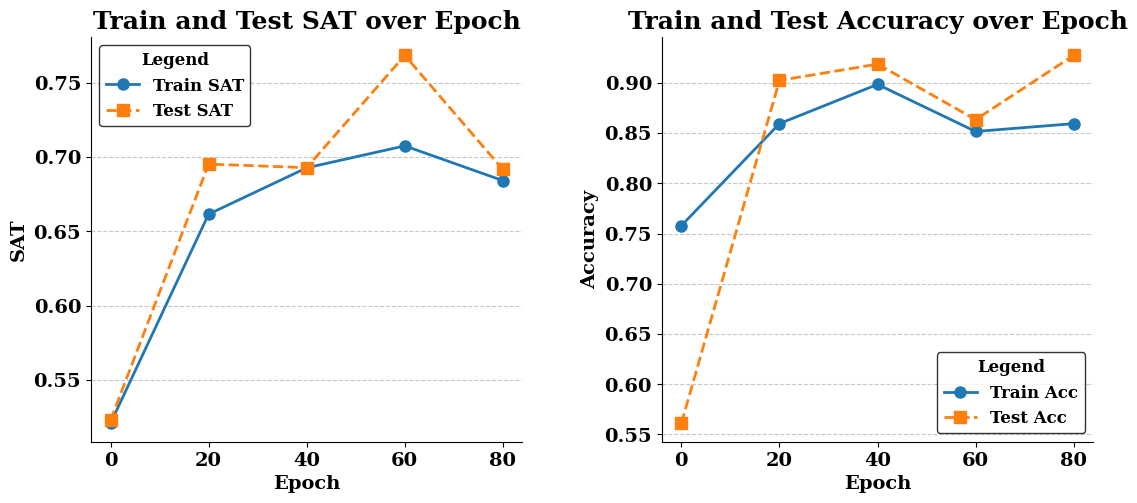

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

font = {'family': 'serif', 'weight': 'bold', 'size': 14}
plt.rc('font', **font)

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Train and Test SAT over Epoch
axs[0].plot(epoch_list, train_sat_list, label='Train SAT', linewidth=2, linestyle='-', marker='o', markersize=8, color='#1f77b4')
axs[0].plot(epoch_list, test_sat_list, label='Test SAT', linewidth=2, linestyle='--', marker='s', markersize=8, color='#ff7f0e')
axs[0].set_xlabel('Epoch', fontsize=14, fontweight='bold', fontfamily='serif')
axs[0].set_ylabel('SAT', fontsize=14, fontweight='bold', fontfamily='serif')
axs[0].set_title('Train and Test SAT over Epoch', fontsize=18, fontweight='bold', fontfamily='serif')
axs[0].legend(loc='best', fontsize=12, framealpha=0.8, title_fontsize=12, title='Legend', edgecolor='black')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Plot 2: Train and Test Accuracy over Epoch
axs[1].plot(epoch_list, train_acc_list, label='Train Acc', linewidth=2, linestyle='-', marker='o', markersize=8, color='#1f77b4')
axs[1].plot(epoch_list, test_acc_list, label='Test Acc', linewidth=2, linestyle='--', marker='s', markersize=8, color='#ff7f0e')
axs[1].set_xlabel('Epoch', fontsize=14, fontweight='bold', fontfamily='serif')
axs[1].set_ylabel('Accuracy', fontsize=14, fontweight='bold', fontfamily='serif')
axs[1].set_title('Train and Test Accuracy over Epoch', fontsize=18, fontweight='bold', fontfamily='serif')
axs[1].legend(loc='best', fontsize=12, framealpha=0.8, title_fontsize=12, title='Legend', edgecolor='black')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust spacing between subplots
fig.tight_layout(pad=3.0)

plt.show()

# Prediction Stacking using Decision Trees (DTs)

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

In [53]:
df = pd.read_csv('/content/wine_dataset.csv')
df.drop('quality', axis=1, inplace=True)
df['style'] = np.where(df['style'] == 'red', True, False)
df = df.sample(frac=1)
features = df.drop('style', axis=1)
features = (features - features.mean()) / features.std()
labels = df['style']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Training our NSAI model

In [56]:
dt = DecisionTreeClassifier(random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(64,), random_state=42)

In [57]:
estimators = [('dt', dt), ('nn', nn)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=nn)

In [58]:
stacking_clf.fit(X_train, y_train)
print(f"accuracy: {stacking_clf.score(X_test, y_test):.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy: 0.997


## Prediction interpretability and logic tracing

In [61]:
from sklearn.tree import export_text

# Get the DT classifier from the stacking classifier
dt_clf = stacking_clf.estimators_[0]

# Convert the DT to rules using export_text
tree_rules = export_text(dt_clf, feature_names=X_train.columns.tolist())

# Parse the text representation of the rules to create a list of rules
rule_list = [ rule.strip() for rule in tree_rules.split('\n') if rule.strip() ]
print(rule_list)

['|--- total_sulfur_dioxide <= -0.87', '|   |--- chlorides <= -0.27', '|   |   |--- density <= -0.10', '|   |   |   |--- pH <= 3.34', '|   |   |   |   |--- total_sulfur_dioxide <= -1.78', '|   |   |   |   |   |--- chlorides <= -0.70', '|   |   |   |   |   |   |--- class: 0', '|   |   |   |   |   |--- chlorides >  -0.70', '|   |   |   |   |   |   |--- class: 1', '|   |   |   |   |--- total_sulfur_dioxide >  -1.78', '|   |   |   |   |   |--- chlorides <= -0.30', '|   |   |   |   |   |   |--- class: 0', '|   |   |   |   |   |--- chlorides >  -0.30', '|   |   |   |   |   |   |--- volatile_acidity <= -0.09', '|   |   |   |   |   |   |   |--- class: 0', '|   |   |   |   |   |   |--- volatile_acidity >  -0.09', '|   |   |   |   |   |   |   |--- class: 1', '|   |   |   |--- pH >  3.34', '|   |   |   |   |--- class: 1', '|   |   |--- density >  -0.10', '|   |   |   |--- residual_sugar <= -0.15', '|   |   |   |   |--- class: 1', '|   |   |   |--- residual_sugar >  -0.15', '|   |   |   |   |--- c

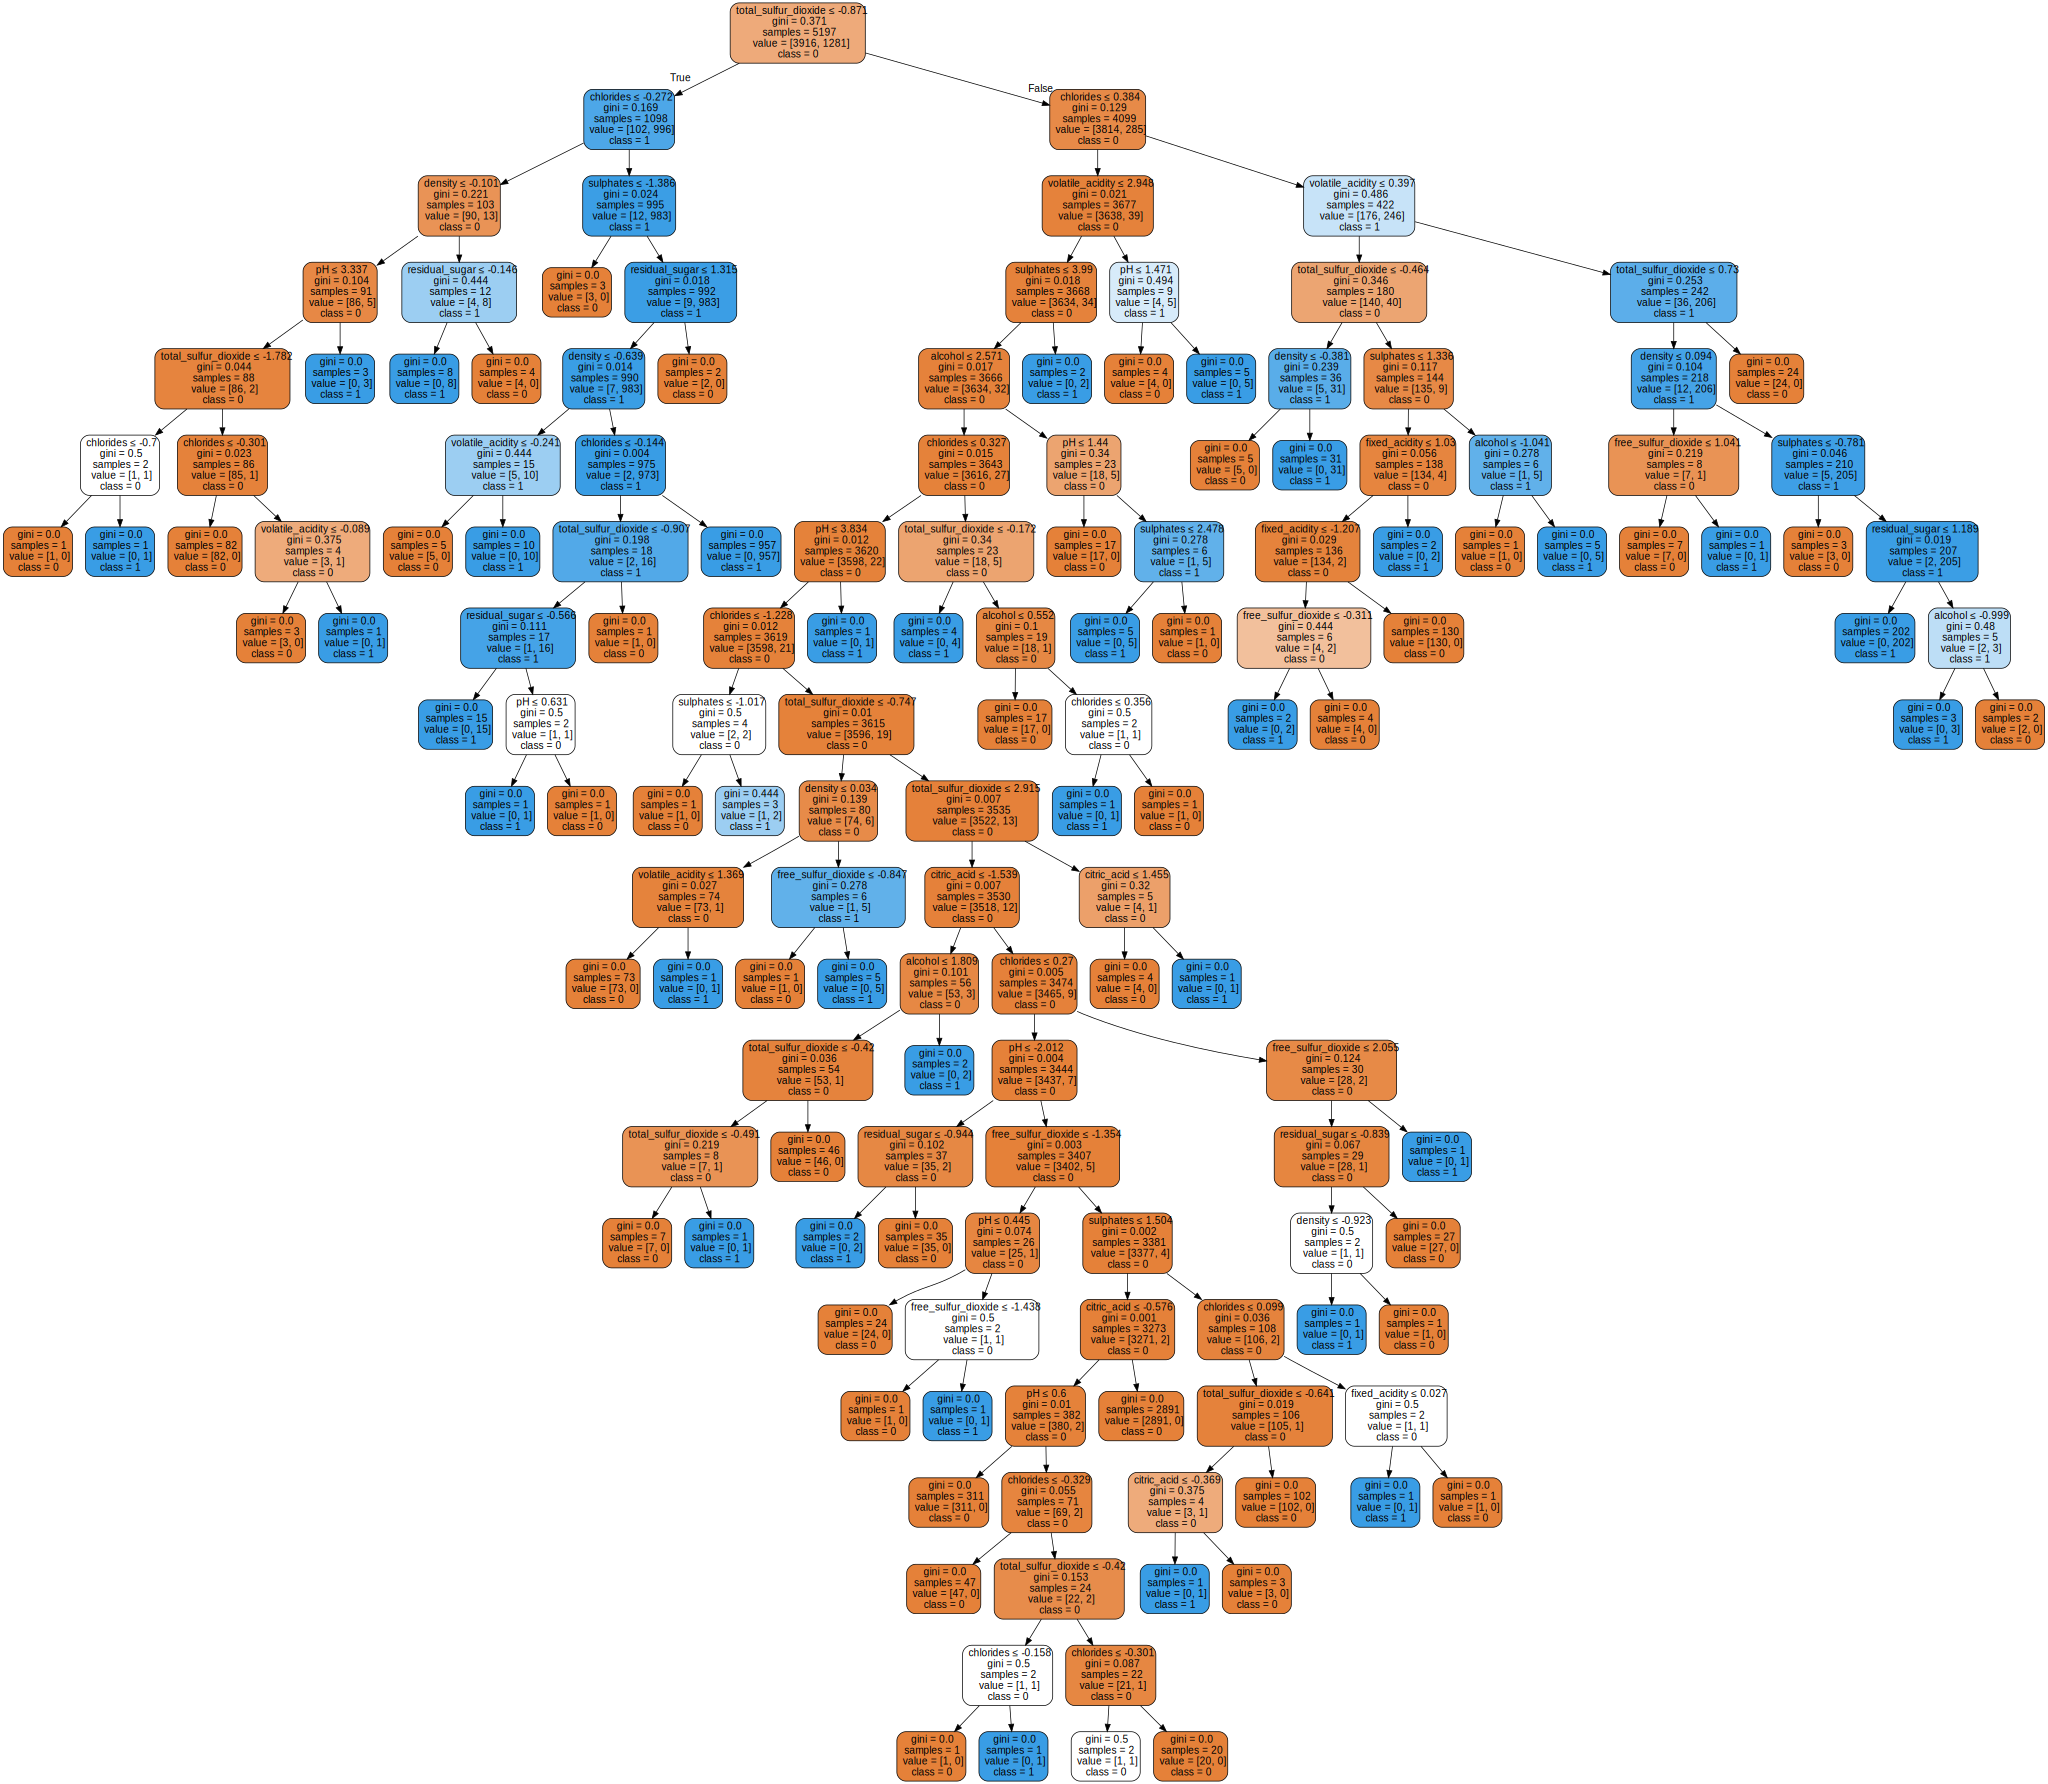

In [62]:
# Let's visualize the text repr into a visual graph
from sklearn. tree import export_graphviz
import graphviz

# Export the DT as a Graphviz file
dot_data = export_graphviz(
    dt_clf, out_file=None, feature_names=X_train.columns, class_names=['0', '1'], filled=True, rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)

# Showing the decision tree
graph